## Environment setup

In [28]:
%matplotlib inline
import ipywidgets as widgets

In [29]:
# import library
import numpy as np
import random
import math
from matplotlib import pyplot as plt
import os

# parameters
BATCH_SIZE = 64
NUM_EPOCH = 20
MODEL_PATH = './model'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    os.makedirs(os.path.join(MODEL_PATH, "MLP"))
    os.makedirs(os.path.join(MODEL_PATH, "CNN"))
    os.makedirs(os.path.join(MODEL_PATH, "CAN"))
USE_TRAINED = True

# dataset
train_images = np.fromfile('./MNIST/train-images.idx3-ubyte', dtype=np.uint8)[0x10:].reshape((-1, 28, 28))
train_labels = np.fromfile('./MNIST/train-labels.idx1-ubyte', dtype=np.uint8)[0x08:]
test_images = np.fromfile('./MNIST/t10k-images.idx3-ubyte', dtype=np.uint8)[0x10:].reshape((-1, 28, 28))
test_labels = np.fromfile('./MNIST/t10k-labels.idx1-ubyte', dtype=np.uint8)[0x08:]

Text(0.5, 1.0, '6')

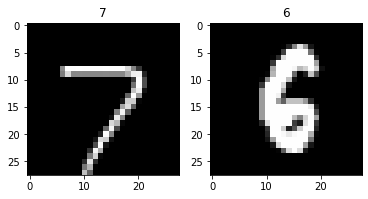

In [30]:
# test for printing the dataset
idx1 = int(train_images.shape[0] * random.random())
idx2 = int(test_images.shape[0] * random.random())
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_images[idx1].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
ax[0].set_title(str(train_labels[idx1]), fontsize=12)
ax[1].imshow(test_images[idx2].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
ax[1].set_title(str(test_labels[idx2]), fontsize=12)

# K Nearest Neightbors (KNN)

In [31]:
# import library
from sklearn.neighbors import KNeighborsClassifier

### Setup KNN

In [32]:
def knn_init(k, train_images, train_labels):
    #reshape images
    train_images = train_images.reshape((-1, 28*28))
    knn = KNeighborsClassifier(n_neighbors=k, p=1, n_jobs=-1) # p=1 in minkowski metric means using manhattan distance, which is SAD
    knn.fit(train_images, train_labels)
    return knn

### Test K=1

Text(0.5, 1.0, 'predict: 7 actual: 7')

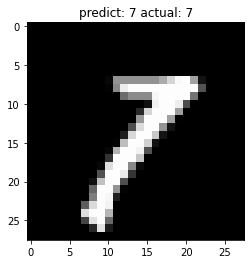

In [33]:
knn = knn_init(1, train_images, train_labels)

test_idx = int(test_images.shape[0] * random.random())
predict_class = knn.predict(test_images[test_idx].reshape((-1,28*28)))
fig, ax = plt.subplots()
ax.imshow(test_images[test_idx].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
ax.set_title("predict: "+str(predict_class[0])+" actual: " + str(test_labels[test_idx]), fontsize=12)

### What will be the accuracy if we find the nearest neighbor?

In [34]:
knn = knn_init(1, train_images, train_labels) #nearest neighbor means k=1
accuracy = knn.score(test_images.reshape((-1, 28*28)), test_labels)
print(accuracy)

0.9631


### Plot a curve of accuracy versus K from 1 to 10

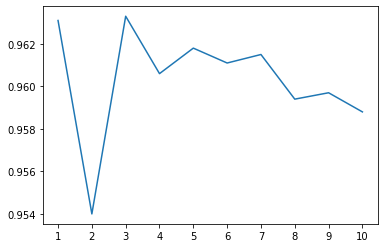

[0.9631, 0.954, 0.9633, 0.9606, 0.9618, 0.9611, 0.9615, 0.9594, 0.9597, 0.9588]


In [35]:
accuracy = []
for i in range(10):
    knn = knn_init(i+1, train_images, train_labels)
    accuracy.append(knn.score(test_images.reshape((-1, 28*28)), test_labels))
plt.plot(accuracy)
plt.xticks(range(10), range(1,11))
plt.show()
print(accuracy)

# Multilayer Perceptron (MLP)

In [4]:
# import library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# parameters
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define MLP Network

In [5]:
class MLP(nn.Module):
    def __init__(self, num_neurons):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(28*28, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### Define MNIST MLP Dataset

In [6]:
class MNIST_MLP_Dataset(Dataset):
    def __init__(self, images, labels) -> None:
        super().__init__()
        self.images = torch.from_numpy((images.reshape((-1, 28*28))/255).astype(np.float32))
        self.labels = torch.from_numpy(labels).long()
        self.len = images.shape[0]

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.len

training_set = MNIST_MLP_Dataset(train_images, train_labels)
validation_set = MNIST_MLP_Dataset(test_images, test_labels)

### Training function

In [7]:
def mlp_train(mlp, training_set, validation_set):
    training_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

    training_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=NUM_EPOCH,
        step=1,
        description='Progress:',
        bar_style='success',
        orientation='horizontal'
    )
    train_loss_text = widgets.Label(value="average train loss: ")
    val_loss_text = widgets.Label(value="average validation loss: ")
    vbox = widgets.VBox([training_progress, train_loss_text, val_loss_text])
    display(vbox)

    for epoch in range(NUM_EPOCH):
        # print("EPOCH " + str(epoch) + ":")
        mlp.train(True)
        avg_loss = 0
        iter_cnt = 0
        for i, data in enumerate(training_loader):
            images, labels = data
            images = images.to(device = device)
            labels = labels.to(device = device)
            optimizer.zero_grad()
            outputs = mlp(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            iter_cnt += 1
        avg_loss /= iter_cnt
        # print("average train loss: " + str(avg_loss))
        train_loss_text.value = 'average train loss: ' + str(avg_loss)
        mlp.train(False)

        validation_loss = 0
        for i, data in enumerate(validation_loader):
            images, labels = data
            images = images.to(device = device)
            labels = labels.to(device = device)
            outputs = mlp(images)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
        validation_loss /= (i+1)
        # print("average validation loss: " + str(validation_loss))
        val_loss_text.value = 'average validation loss: ' + str(validation_loss)
        training_progress.value = epoch+1

In [8]:
mlp = MLP(256)
mlp = mlp.to(device = device)

if USE_TRAINED and os.path.exists(os.path.join(MODEL_PATH, 'MLP', '256neurons.pt')):
    mlp.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'MLP', '256neurons.pt')))
else:
    mlp_train(mlp, training_set, validation_set)

Text(0.5, 1.0, 'predict: 0 actual: 0')

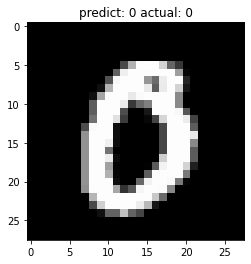

In [12]:
test_idx = int(test_images.shape[0] * random.random())
images, labels = validation_set[test_idx]
images = images.to(device = device)
labels = labels.to(device = device)
outputs = mlp(images)
fig, ax = plt.subplots()
ax.imshow(images.cpu().numpy().reshape((28,28))*255, cmap='gray', vmin=0, vmax=255)
ax.set_title("predict: "+str(outputs.argmax().item())+" actual: " + str(labels.item()), fontsize=12)

### Plot a curve of accuracy versus the number of neurons

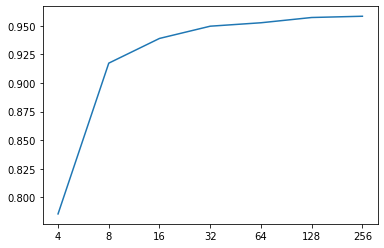

[0.7855, 0.9173, 0.9389, 0.9496, 0.9526, 0.9572, 0.9583]


In [13]:
accuracy = []
num_neurons = [4, 8, 16, 32, 64, 128, 256]
validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
for i in num_neurons:
    mlp = MLP(i)
    mlp = mlp.to(device = device)
    if USE_TRAINED and os.path.exists(os.path.join(MODEL_PATH, 'MLP', "{}neurons.pt".format(i))):
        mlp.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'MLP', "{}neurons.pt".format(i))))
    else:
        mlp_train(mlp, training_set, validation_set)
    correct = 0
    img_cnt = 0
    with torch.no_grad():
        for j, data in enumerate(validation_loader):
            images, labels = data
            images = images.to(device = device)
            outputs = mlp(images)
            outputs = outputs.cpu().numpy().argmax(axis=1)
            labels = labels.cpu().numpy()
            correct += np.sum(outputs==labels)
            img_cnt += labels.shape[0]
    accuracy.append(correct / img_cnt)
    # save model
    torch.save(mlp.state_dict(), os.path.join(MODEL_PATH, 'MLP', "{}neurons.pt".format(i)))
    del mlp
plt.plot(accuracy)
plt.xticks(range(len(num_neurons)), num_neurons)
plt.show()
print(accuracy)

# Convolutional Neural Networks (CNN)

In [14]:
# import library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# parameters
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define CNN Network (LeNet-5)

In [15]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)    # output size: {(W-K+2P)/S)}+1 = {(28-5+0)/1)}+1 = 24
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                  # output size: 24/2 = 12
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)   # output size: {(W-K+2P)/S)}+1 = {(12-5+0)/1)}+1 = 8
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)                  # output size: 8/2 = 4
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*4*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.avg_pool1(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.avg_pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

### Define MNIST CNN Dataset

In [16]:
class MNIST_CNN_Dataset(Dataset):
    def __init__(self, images, labels) -> None:
        super().__init__()
        self.images = torch.from_numpy((images.reshape((-1, 1, 28, 28))/255).astype(np.float32))
        self.labels = torch.from_numpy(labels).long()
        self.len = images.shape[0]

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.len

training_set = MNIST_CNN_Dataset(train_images, train_labels)
validation_set = MNIST_CNN_Dataset(test_images, test_labels)

### Training function

In [17]:
def cnn_train(cnn, training_set, validation_set):
    training_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    optimizer = torch.optim.Adam(cnn.parameters())

    training_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=NUM_EPOCH,
        step=1,
        description='Progress:',
        bar_style='success',
        orientation='horizontal'
    )
    train_loss_text = widgets.Label(value="average train loss: ")
    val_loss_text = widgets.Label(value="average validation loss: ")
    vbox = widgets.VBox([training_progress, train_loss_text, val_loss_text])
    display(vbox)

    for epoch in range(NUM_EPOCH):
        # print("EPOCH " + str(epoch) + ":")
        cnn.train(True)
        avg_loss = 0
        iter_cnt = 0
        for i, data in enumerate(training_loader):
            images, labels = data
            images = images.to(device = device)
            labels = labels.to(device = device)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            iter_cnt += 1
        avg_loss /= iter_cnt
        # print("average train loss: " + str(avg_loss))
        train_loss_text.value = 'average train loss: ' + str(avg_loss)
        cnn.train(False)

        validation_loss = 0
        for i, data in enumerate(validation_loader):
            images, labels = data
            images = images.to(device = device)
            labels = labels.to(device = device)
            outputs = cnn(images)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
        validation_loss /= (i+1)
        # print("average validation loss: " + str(validation_loss))
        val_loss_text.value = 'average validation loss: ' + str(validation_loss)
        training_progress.value = epoch+1

In [18]:
cnn = LeNet5()
cnn = cnn.to(device = device)

if USE_TRAINED and os.path.exists(os.path.join(MODEL_PATH, 'CNN', 'cnn.pt')):
    cnn.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'CNN', 'cnn.pt')))
else:
    cnn_train(cnn, training_set, validation_set)
    # save model
    torch.save(cnn.state_dict(), os.path.join(MODEL_PATH, 'CNN', "cnn.pt"))

Text(0.5, 1.0, 'predict: 4 actual: 4')

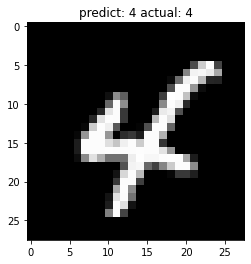

In [19]:
test_idx = int(test_images.shape[0] * random.random())
images, labels = validation_set[test_idx]
images = images.reshape(-1,1,28,28).to(device = device)
labels = labels.to(device = device)
outputs = cnn(images)
fig, ax = plt.subplots()
ax.imshow(images.cpu().numpy().reshape((28,28))*255, cmap='gray', vmin=0, vmax=255)
ax.set_title("predict: "+str(outputs.argmax().item())+" actual: " + str(labels.item()), fontsize=12)

### Accuracy

In [20]:
accuracy = 0
validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
with torch.no_grad():
    correct = 0
    img_cnt = 0
    for i, data in enumerate(validation_loader):
        images, labels = data
        images = images.to(device = device)
        outputs = cnn(images)
        outputs = outputs.cpu().numpy().argmax(axis=1)
        labels = labels.cpu().numpy()
        correct += np.sum(outputs==labels)
        img_cnt += labels.shape[0]
    accuracy = correct / img_cnt
print(accuracy)

0.9881


# Context Aggregation Networks (CAN)

In [21]:
# import library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# parameters
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define CAN Network

In [22]:
class CAN(nn.Module):
    def __init__(self, feature_channels):
        super(CAN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=feature_channels, 
                               kernel_size=3, 
                               dilation=1,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=feature_channels, 
                               out_channels=feature_channels, 
                               kernel_size=3,
                               dilation=2,
                               padding=2)
        self.conv3 = nn.Conv2d(in_channels=feature_channels, 
                               out_channels=feature_channels, 
                               kernel_size=3,
                               dilation=4,
                               padding=4)
        self.conv4 = nn.Conv2d(in_channels=feature_channels, 
                               out_channels=feature_channels, 
                               kernel_size=3,
                               dilation=8,
                               padding=8)
        self.conv5 = nn.Conv2d(in_channels=feature_channels, 
                               out_channels=10, 
                               kernel_size=3,
                               dilation=1,
                               padding=1)
        self.avg_pool1 = nn.AvgPool2d(kernel_size=28)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.conv5(x)
        x = F.leaky_relu(x)
        x = self.avg_pool1(x)
        x = torch.squeeze(x)
        return x

### Define MNIST CAN Dataset (same as CNN)

In [23]:
class MNIST_CNN_Dataset(Dataset):
    def __init__(self, images, labels) -> None:
        super().__init__()
        self.images = torch.from_numpy((images.reshape((-1, 1, 28, 28))/255).astype(np.float32))
        self.labels = torch.from_numpy(labels).long()
        self.len = images.shape[0]

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.len

training_set = MNIST_CNN_Dataset(train_images, train_labels)
validation_set = MNIST_CNN_Dataset(test_images, test_labels)

### Training function

In [24]:
def can_train(can, training_set, validation_set):
    training_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    optimizer = torch.optim.Adam(can.parameters())

    training_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=NUM_EPOCH,
        step=1,
        description='Progress:',
        bar_style='success',
        orientation='horizontal'
    )
    train_loss_text = widgets.Label(value="average train loss: ")
    val_loss_text = widgets.Label(value="average validation loss: ")
    vbox = widgets.VBox([training_progress, train_loss_text, val_loss_text])
    display(vbox)

    for epoch in range(NUM_EPOCH):
        # print("EPOCH " + str(epoch) + ":")
        can.train(True)
        avg_loss = 0
        iter_cnt = 0
        for i, data in enumerate(training_loader):
            images, labels = data
            images = images.to(device = device)
            labels = labels.to(device = device)
            optimizer.zero_grad()
            outputs = can(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            iter_cnt += 1
        avg_loss /= iter_cnt
        # print("average train loss: " + str(avg_loss))
        train_loss_text.value = 'average train loss: ' + str(avg_loss)
        can.train(False)

        validation_loss = 0
        for i, data in enumerate(validation_loader):
            images, labels = data
            images = images.to(device = device)
            labels = labels.to(device = device)
            outputs = can(images)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
        validation_loss /= (i+1)
        # print("average validation loss: " + str(validation_loss))
        val_loss_text.value = 'average validation loss: ' + str(validation_loss)
        training_progress.value = epoch+1

In [36]:
can = CAN(32)
can = can.to(device = device)

if USE_TRAINED and os.path.exists(os.path.join(MODEL_PATH, 'CAN', '32features.pt')):
    can.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'CAN', '32features.pt')))
else:
    can_train(can, training_set, validation_set)

Text(0.5, 1.0, 'predict: 1 actual: 1')

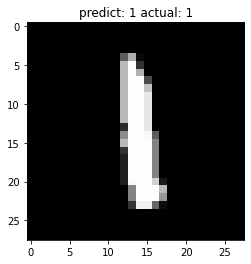

In [37]:
test_idx = int(test_images.shape[0] * random.random())
images, labels = validation_set[test_idx]
images = images.reshape(-1,1,28,28).to(device = device)
labels = labels.to(device = device)
outputs = can(images)
fig, ax = plt.subplots()
ax.imshow(images.cpu().numpy().reshape((28,28))*255, cmap='gray', vmin=0, vmax=255)
ax.set_title("predict: "+str(outputs.argmax().item())+" actual: " + str(labels.item()), fontsize=12)

### Accuracy

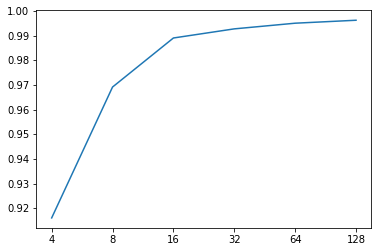

[0.9161, 0.9692, 0.9891, 0.9928, 0.9951, 0.9963]


In [38]:
accuracy = []
num_feature = [4, 8, 16, 32, 64, 128]
validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
for i in num_feature:
    can = CAN(i)
    can = can.to(device = device)
    if USE_TRAINED and os.path.exists(os.path.join(MODEL_PATH, 'CAN', "{}features.pt".format(i))):
        can.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'CAN', "{}features.pt".format(i))))
    else:
        can_train(can, training_set, validation_set)
    correct = 0
    img_cnt = 0
    with torch.no_grad():
        for j, data in enumerate(validation_loader):
            images, labels = data
            images = images.to(device = device)
            outputs = can(images)
            outputs = outputs.cpu().numpy().argmax(axis=1)
            labels = labels.cpu().numpy()
            correct += np.sum(outputs==labels)
            img_cnt += labels.shape[0]
    accuracy.append(correct / img_cnt)
    # save model
    torch.save(can.state_dict(), os.path.join(MODEL_PATH, 'CAN', "{}features.pt".format(i)))
    del can
plt.plot(accuracy)
plt.xticks(range(len(num_feature)), num_feature)
plt.show()
print(accuracy)